In [1]:
from gradcam import GradCAM, GradCAMpp
from gradcam.utils import visualize_cam, Normalize
from PIL import Image
from torchvision import models, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from lime import lime_image
from skimage.segmentation import mark_boundaries

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cuda', index=0)

In [2]:
# Load a pretrained ResNet18 model
loaded_model = models.resnet18(weights=True)

# Modify the fully connected layer to match the model you trained
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, 2)

# Load the saved state dictionary from the trained model
loaded_model.load_state_dict(torch.load("models/best_model.pth"))
loaded_model.eval()

loaded_model = loaded_model.to(device)

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\predator\AppData\Local\Temp\ipykernel_21048\2833120131.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary ob

## 1. Grad-CAM (Gradient-weighted Class Activation Mapping)

In [3]:
# Preprocess input image
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# Load and transform the image
img_path = "data_smiles/Training_Group/Hepatotoxicity/173254.png"
img = Image.open(img_path).convert("RGB")  # Load image
input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Apply normalization (this is where the batch dimension is needed)
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalize(input_tensor)  # Now the input tensor is 4D

In [10]:
# Define the target layers (last convolutional layer of ResNet)
target_layer = loaded_model.layer4[
    -1
]  # layer4 is typically the target layer for ResNet

# Initialize Grad-CAM and Grad-CAM++
gradcam = GradCAM(loaded_model, target_layer)
gradcam_pp = GradCAMpp(loaded_model, target_layer)

# Generate Grad-CAM and Grad-CAM++ heatmaps
mask, _ = gradcam(input_tensor)
mask_pp, _ = gradcam_pp(input_tensor)

# Convert input image back to tensor for visualization
img_tensor = transform(img).unsqueeze(0)  # Keeping the input image as a tensor
img_tensor = img_tensor.squeeze().cpu()  # Remove batch dimension for visualization

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\gradcam\gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\gradcam\gradcam.py:147: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)


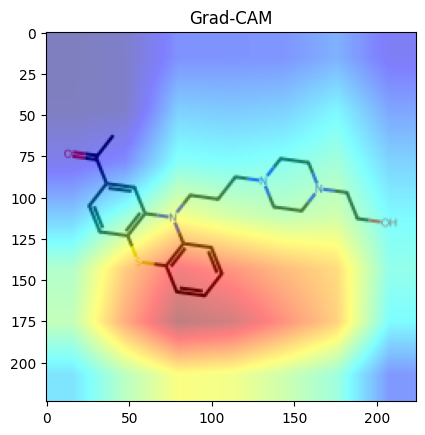

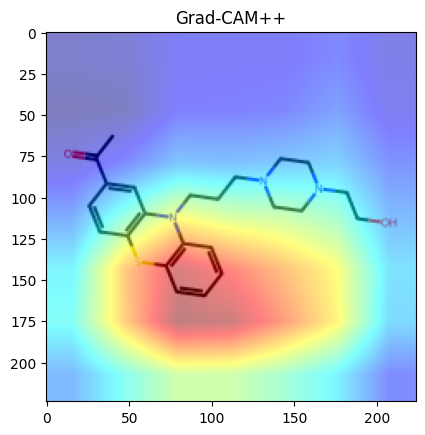

In [15]:
# Visualize and display Grad-CAM heatmap
heatmap, result = visualize_cam(mask, img_tensor)
plt.imshow(result.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title("Grad-CAM")
plt.show()

# Visualize and display Grad-CAM++ heatmap
heatmap_pp, result_pp = visualize_cam(mask_pp, img_tensor)
plt.imshow(result_pp.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
plt.title("Grad-CAM++")
plt.show()

## 2. LIME (Local Interpretable Model-Agnostic Explanations)

100%|██████████| 100/100 [00:00<00:00, 209.67it/s]


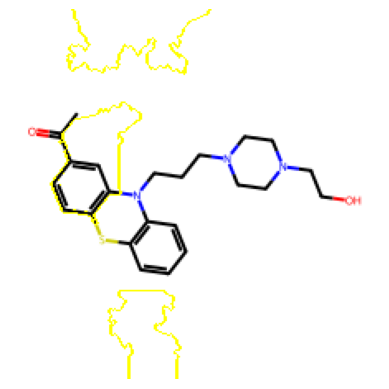

In [10]:
# Preprocessing for the image
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.975, 0.971, 0.974], [0.140, 0.148, 0.142]),
    ]
)


# Function to get predictions from the model
def batch_predict(images):
    # Convert images from numpy arrays back to tensors and apply transformations
    loaded_model.eval()
    batch = torch.stack(
        [transform(Image.fromarray(image)) for image in images], dim=0
    ).to(device)

    # Get model predictions
    outputs = loaded_model(batch)

    # Convert model output (logits) to probabilities
    probs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()

    return probs


# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Load an example image
img_path = "data_smiles/Training_Group/Hepatotoxicity/173254.png"
img = Image.open(img_path)

# Explain the model's prediction on the image
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,  # Use batch_predict as the function for LIME
    top_labels=2,  # Assuming binary classification
    hide_color=0,
    num_samples=100,
)  # Number of perturbations to generate

# Get the explanation for the top class
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)
img_boundaries = mark_boundaries(temp / 255.0, mask)

# Display the result
plt.imshow(img_boundaries)
plt.axis("off")
plt.show()

## 3. SHAP: Feature Importance using SHapley Additive exPlanations


In [ ]:
# Load a pretrained ResNet18 model
loaded_model = models.resnet18(weights=True)

# Modify the fully connected layer to match the model you trained
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, 2)

# Load the saved state dictionary from the trained model
loaded_model.load_state_dict(torch.load("models/best_model.pth"))
loaded_model.eval()

loaded_model = loaded_model.to(device)

In [2]:
# Load pre-trained ResNet18 model
model = models.resnet18(weights=True)
model.fc = torch.nn.Linear(
    model.fc.in_features, 2
)  # Update FC layer if binary classification

# Set model to evaluation mode
model.eval()

# Image preprocessing
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
img_path = "data_smiles/Training_Group/Hepatotoxicity/173254.png"
img = Image.open(img_path)
input_tensor = transform(img).unsqueeze(0)

c:\Users\predator\anaconda3\envs\dili\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import shap
import numpy as np

# Create a background dataset to compute expectations
background = torch.randn(
    100, 3, 224, 224
)  # Create random background data for illustration

# Initialize DeepExplainer with the model and background data
explainer = shap.DeepExplainer(model, background)

# Explain the predictions on the input image
shap_values = explainer.shap_values(input_tensor)

# Visualize the SHAP values
shap.image_plot(shap_values, input_tensor)

## 4. Captum: Integrated Gradients, DeepLIFT, and more


In [ ]:
import torch
from captum.attr import IntegratedGradients, DeepLift, NoiseTunnel, visualization as viz

# Create the Integrated Gradients object
ig = IntegratedGradients(model)

# Generate attributions for the input image
attributions, delta = ig.attribute(
    input_tensor, target=0, return_convergence_delta=True
)

# Visualize the attributions
_ = viz.visualize_image_attr(
    np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    np.transpose(input_tensor.squeeze().cpu().detach().numpy(), (1, 2, 0)),
    method="heat_map",
    sign="all",
    show_colorbar=True,
    title="Integrated Gradients",
)

# 5. XSMILES

In [1]:
import xsmiles
import json

print("XSMILES version:", xsmiles.__version__)

XSMILES version: 0.2.2


In [8]:
molecule_with_sequence = {          
          'string': 'CCCCCCCC(=O)Oc1c(Br)cc(C#N)cc1Br',
          
          # Optional sequence, in case the app cannot parse your string correctly you can try and split it and input together with the original string
          'sequence': ["C","C", "C", "C", "C", "C", "C", "C", "(", "=", "O", ")", "O", "c", "1", "c", "(", "Br", ")", "c", "c", "(", "C", "#", "N", ")", "c", "c","1", "Br" ],
        
          'methods': [{
            'name': 'logBCF perturb',
            'scores': [
              -0.1762678623199463, -0.25460100173950195, -0.2712419033050537,
              -0.2308177947998047, -0.12025833129882812, -0.13311767578125,
              -0.16690635681152344, -0.27755022048950195, -0.38324832916259766,
              -0.2450413703918457, -0.3898346424102783, -0.22409844398498535,
              -0.2113962173461914, -0.12725472450256348, -0.04010510444641113,
              -0.01143336296081543, -0.05576324462890625, 0.18838262557983398,
              0.0361400842666626, 0.0019290447235107422, 0.0008728504180908203,
              -0.028931856155395508, 0.05310940742492676, 0.35703766345977783,
              -0.16322708129882812, 0.07348740100860596, -0.037914276123046875,
              0.0180361270904541, -0.047339677810668945, 0.06556379795074463,
            ],
          }],
          'attributes': {
            'predicted': 5.300230503082275,          
            'measured': 3.284126043319702,
            'Compound ID': 'bromoxynil octanoate',
          },
        }

xsmiles.XSmilesWidget(molecules=json.dumps([molecule_with_sequence]))

XSmilesWidget(molecules='[{"string": "CCCCCCCC(=O)Oc1c(Br)cc(C#N)cc1Br", "sequence": ["C", "C", "C", "C", "C",…

In [4]:
view_config = {
    "hideBarChart": False,
    "hideAttributesTable": True,
    "drawerType": "RDKitDrawer",  # Possible values RDKitDrawer (colored) or RDKitDrawer_black (black).
}

In [11]:
%%script false --no-raise-error

molecules = [molecule_with_sequence]

# Colors and heatmap configuration
gradient_config = {
    "palette": "PiYG_5",  # default: PiYG_5.
    "thresholds": [],  # default []
    "colorDomain": [-0.25, 0, 0.25],  # default: [-1,0,1]
    "radius": {"min": 15, "max": 100},  # default: {'min': 15, 'max': 40}
    "opacity": {"min": 0, "max": 1},  # default: {'min': 0.6, 'max': 1}
    "blur": 0.8,  # default: 0.7
}

# Currently XSMILES widget only accepts the python dict in json-text format.
# Use json.dumps() as here:
xsmiles.XSmilesWidget(
    molecules=json.dumps(molecules),
    gradient_config=json.dumps(gradient_config),
    view_config=json.dumps(view_config),
)

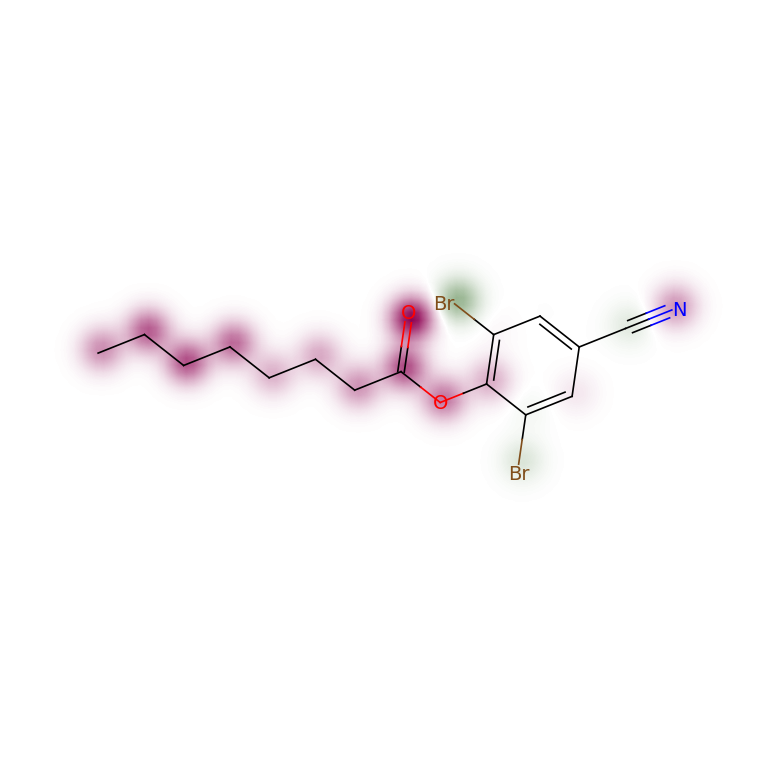

In [9]:
compare_with_rdkit = True #use false if you don't have it installed or don't want to
if compare_with_rdkit:
    import rdkit # make sure you have RDKit installed to run this notebook: pip install rdkit-pypi
    from rdkit.Chem.Draw import SimilarityMaps
    from io import BytesIO
    from PIL import Image

    def draw(mol, width=250, d = None):            
        d.FinishDrawing()    
        stream = BytesIO(d.GetDrawingText())
        return Image.open(stream)

    mol = rdkit.Chem.MolFromSmiles(molecule_with_sequence['string'])
    smiles_scores = molecule_with_sequence['methods'][0]['scores']
    smiles_sequence = molecule_with_sequence['sequence']
    scores = [smiles_scores[i] for i in range(len(smiles_scores)) if smiles_sequence[i] in ["C","O","c","Br","N"]]  #CCCCCCCC(=O)Oc1c(Br)cc(C#N)cc1Br
    width = 300

    #GetSimilarityMapFromWeights(mol, weights, colorMap=None, scale=- 1, size=250, 250, sigma=None, coordScale=1.5, step=0.01, colors='k', contourLines=10, alpha=0.5, draw2d=None, **kwargs)¶
    fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, scores, size=(width,width), contourLines=0, scale=-1)